In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel, LinearKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
# from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None, linear = False, bias = False):
    x_train = []
    y_train = []
    train_range = []
    x_train_timestamp = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    scaler_range = StandardScaler()

    # train
    for key, values in train.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"Data/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
      
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        train_range.extend(jnp.max(x, axis=1)-jnp.min(x, axis=1))
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train_range = jnp.array(train_range).reshape(-1, 1)

    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)
    x_train_range = scaler_range.fit_transform(x_train_range)


    # test
    x_test = []
    y_test = []
    test_range = []
    x_test_timestamp = []
    x_test_timestamp_true =[]
    for key, values in test.items():
        for app in range(len(appliances)):
            df = pd.read_csv(
                f"Data/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[app]])
            df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
            startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
            endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

            if startDate > endDate:
                raise "Start Date must be smaller than Enddate."

            df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
            df.dropna(inplace=True)
            if app == 0:
                    x = df[appliances[app]].values
            else:
                x += df[appliances[app]].values
            if appliances[app] == "Refrigerator":
                y = df[appliances[app]].values
        
        if (bias == True):
            x =  x + 100*np.ones(x.shape[0])
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        test_range.append(jnp.max(x, axis=1)-jnp.min(x, axis=1))
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)
    x_test_range = jnp.array(test_range).reshape(-1, 1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
    x_test_range = scaler_range.transform(x_test_range)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n)
    y_train = jnp.array(y_train)
    x_train_range = jnp.array(x_train_range)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)
    x_test_range = jnp.array(x_test_range).reshape(-1,1)

    if (linear == True):
        n = 100
        x_train = jnp.concatenate((x_train, x_train_range), axis =1).reshape(x_train.shape[0],n)
        x_test = jnp.concatenate((x_test, x_test_range), axis =1).reshape(x_test.shape[0],n)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, x_test_timestamp_true, scaler_x, scaler_y, scaler_time, scaler_range


In [5]:
train ={1:{
                    'start_time': "2011-04-28" ,
                    'end_time': "2011-05-15"
                }, 3: {
                'start_time': "2011-04-19" ,
                'end_time': "2011-05-22"
            },
                
      
                }
test = {  2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                }
appliances = ["Microwave", "Refrigerator",  "Dish Washer"] #

In [6]:
x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, x_test_time_true, scaler_x, scaler_y, scaler_time, scaler_range = dataset_load(appliances, train, test, linear=False, bias=False)

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((24918, 99), (15656, 99), (24918, 1), (15656, 1))

In [8]:
x = torch.tensor(np.array(x_train)).to(torch.float32)
y = torch.tensor(np.array(y_train)).reshape(-1,).to(torch.float32)
xt = torch.tensor(np.array(x_test)).to(torch.float32)
yt = torch.tensor(np.array(y_test)).reshape(-1,).to(torch.float32)

In [ ]:


kernel1 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=100 )) #nu=2.5,
kernel2 = ScaleKernel(LinearKernel(active_dims = (99)))

kernel = kernel1 + kernel2
inducing_points =  x[np.arange(0,x.shape[0],20)] 

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                      inducing_points).to("cuda")

loss = model.fit(lr=1e-2, n_epochs=1500,verbose=1,
        random_state=0)

plt.plot(np.asarray(loss[0]))


  

In [9]:
model_name = "Seq_to_pt_final.pt"
torch.save(model.state_dict(), os.path.join(
  "Neurips/models", model_name))

In [10]:

kernel1 = ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=99 )) #nu=2.5,
kernel2 = ScaleKernel(LinearKernel(active_dims = (99)))


kernel = kernel1 #+ kernel2# + kernel2*kernel3
inducing_points =  x[np.arange(0,x.shape[0],20)] 
#x[torch.randperm(x.shape[0])[: batch]].to("cuda")

model = SGPRegressor(x.to("cuda"), y.to("cuda"), kernel,
                       inducing_points).to("cuda")

model_name = "Seq_to_pt_final.pt"
model.load_state_dict(torch.load(
    os.path.join("./models", model_name)))

<All keys matched successfully>

In [11]:
y_pred_arr =[]
pred_dist = model.predict(xt.to("cuda"))

y_pred_arr.append(pred_dist.loc)

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


In [12]:
y_pred_arr1 = []
for i in range(len(y_pred_arr)):
  y_pred_arr1.append(np.array(y_pred_arr[i].cpu()))

In [13]:
y_mean = np.mean(y_pred_arr1, axis =0)
# y_sigma = np.std(y_pred_arr1, axis=0)

y_mean.shape#, y_sigma.shape

y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
# y_sigma = scaler_y.inverse_transform(y_sigma.reshape(-1,1)).squeeze()
print(y_test.shape, y_mean.shape)

y_mean = np.clip(y_mean,0,y_mean.max(),out=y_mean)

(15656, 1) (15656,)


In [14]:
mae = torch.abs(torch.tensor(y_mean) - yt).mean(dim=-1)
mae

tensor(8.7645)

In [15]:
from math import pi
var_pred = pred_dist.variance
var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
# msll = mean_standardized_log_loss(torch.ensor(y_mean), yt)
f_var= torch.tensor(var_pred)
f_mean = torch.tensor(y_mean)
msll = 0.5 * (torch.log(2 * pi * f_var) + torch.square(yt - f_mean) / (2 * f_var)).mean(dim=-1)
msll

tensor(5.2654, dtype=torch.float64)

In [16]:
quantile = 95.0
standard_normal = torch.distributions.Normal(loc=0.0, scale=1.0)
deviation = standard_normal.icdf(torch.as_tensor(0.5 + 0.5 * (quantile / 100)))
std_pred = pred_dist.stddev
std_pred = torch.tensor(scaler_y.inverse_transform(std_pred.reshape(-1,1).detach().cpu()).squeeze())
lower = torch.tensor(y_mean) - deviation * std_pred 
upper = torch.tensor(y_mean) + deviation * std_pred 
n_samples_within_bounds = ((yt > lower) * (yt < upper)).sum(-1)
fraction = n_samples_within_bounds / yt.shape[-1]
qce = torch.abs(fraction - quantile / 100)
qce

tensor(0.0489)

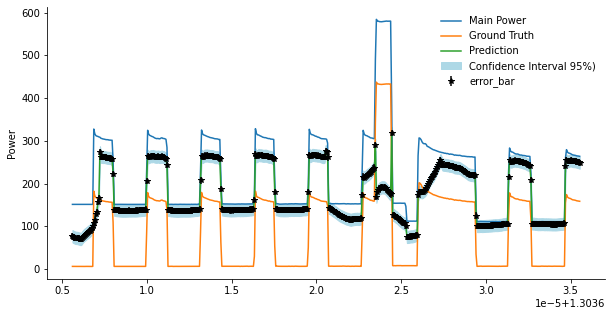

In [18]:
idx = 500
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
start = 4000
var_pred = pred_dist.variance
var_pred = scaler_y.inverse_transform(var_pred.reshape(-1,1).detach().cpu()).squeeze()
time_plot = scaler_time.inverse_transform(x_test_timestamp.cpu().reshape(-1,1))
# latexify(width_scale_factor=2, fig_height=1.75)
ax.plot(time_plot[start : start + idx], scaler_x.inverse_transform(xt[:,:99].cpu())[:,49][start : start + idx], label = "Main Power")
ax.plot(time_plot[start : start + idx], yt.cpu()[start : start + idx], label = "Ground Truth")
ax.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
ax.fill_between(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten() - 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  y_mean[start : start + idx].flatten() + 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  color='lightblue', alpha=1.0, label = "Confidence Interval 95%)")
ax.errorbar(time_plot[start : start + idx].flatten(), y_mean[start : start + idx].flatten(), yerr=np.sqrt(var_pred[start : start + idx]).flatten(), fmt='k*', label = "error_bar")
plt.legend(frameon=False)
ax.set_ylabel("Power" )
sns.despine()
# plt.show()

## Calibration

In [19]:
# from utilities import plot

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import jax.numpy as jnp
from sklearn.metrics import brier_score_loss
from probml_utils import is_latexify_enabled


def calibration_regression(mean, sigma, Y,label, color, ax=None):
    """
    mean : (n_samples,1) or (n_sample,) prediction mean 
    sigma : (n_samples,1) or (n_sample,) prediction sigma 
    Y : (n_samples,1) or (n_sample,) Y co-ordinate of ground truth 
    label :  string, 
    
    
    """

    marker_size = 6 if is_latexify_enabled else None
    if ax is None:
        fig, ax = plt.subplots()
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    k = jnp.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts

    ax.plot(k, counts, color=color, label=label)

    ax.scatter(k, counts, color=color,s=marker_size)
    ax.scatter(k, k,color="green",s=marker_size)
    ax.set_yticks(k)
    ax.set_xticks(k)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    # ax.legend()
    ax.set_xlabel("decile")
    ax.set_ylabel("ratio of points")
    ax.plot(k, k, color="green")
    sns.despine()
    return df, df2

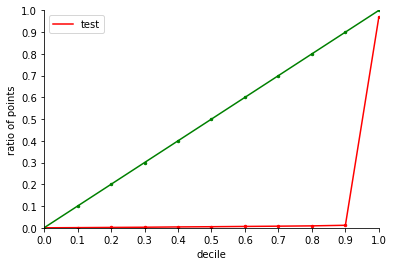

In [20]:
fig, ax = plt.subplots(1)
sigma_pred = jnp.sqrt(var_pred)
df, df1 = calibration_regression(y_mean.squeeze(), sigma_pred.squeeze(), 
                                     yt.squeeze(), "test", "r", ax)
ax.legend()

In [21]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp

def ace(ideal,predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss,in_axes=(0,0))(ideal,predicted))
    
def mass_to_std_factor(mass=0.95):
    rv = norm(0.0, 1.0)
    std_factor = rv.ppf((1.0 + mass) / 2)
    return std_factor

def plot_find_p(y,mean_prediction, std_prediction, mass=0.95):
    std_factor = mass_to_std_factor(mass)
    idx = np.where(
        (y < mean_prediction + std_factor * std_prediction)
        & (y > mean_prediction - std_factor * std_prediction)
    )[0]

    p_hat = len(idx) / len(y)
    return (mass, p_hat)

def find_p_hat(y, mean_prediction,std_prediction):
    out = {}
    for mass in np.linspace(1e-10, 1-1e-20, 1000):
        out[mass] = plot_find_p(y, mean_prediction,std_prediction, mass)[1]
    df = pd.Series(out).to_frame()
    df.index.name = 'p'
    df.columns = ['p_hat']

    return df

In [22]:
cal= find_p_hat(np.array(yt),y_mean,sigma_pred)
p=cal.index

In [23]:
mae = ace(p.values, cal.values)
mae

DeviceArray(0.49330074, dtype=float32)

In [18]:
try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

os.environ["LATEXIFY"] = "1"
os.environ["FIG_DIR"] = "./Figures/"

## Scatter

In [54]:
# x_lin1 = jnp.sort(x_train_full, axis=1)
# x_lin1.shape
x_lin_max = 3000
x_lin = np.linspace(0,x_lin_max,15656).reshape(-1,1) # + 100*np.ones(15656).reshape(-1,1)

x_lin1 = np.array(x_lin).reshape(-1,1)
for i in range(98):
  x_lin1 = np.concatenate((x_lin1, x_lin), axis=1)

# test_range = []
# for i in range(15656):
#   test_range.append(jnp.max(x_lin1[i], axis=0)-jnp.min(x_lin1[i], axis=0))
# test_range = np.array(test_range)
x_lin1.shape
x_lin_scale = scaler_x.transform(x_lin1)
x_new = torch.tensor(np.array(x_lin_scale)).to(torch.float32)
# x_new = torch.cat((torch.tensor(x_lin_scale).reshape(-1,1).to(torch.float32), torch.tensor(x_test_timestamp).reshape(-1,1)),dim=1 ).to(torch.float32)
x_new.shape, x_new.dtype

(torch.Size([15656, 99]), torch.float32)

In [20]:
# x_new = torch.cat((torch.tensor(np.array(x_lin_scale)),torch.tensor(scaler_range.transform(test_range)) )).to(torch.float32)
# # x_new = torch.cat((torch.tensor(x_lin_scale).reshape(-1,1).to(torch.float32), torch.tensor(x_test_timestamp).reshape(-1,1)),dim=1 ).to(torch.float32)
# x_new.shape, x_new.dtype

In [55]:
pred_dist = model.predict(x_new.to("cuda"))
y_mean = pred_dist.loc 
y_mean = scaler_y.inverse_transform(y_mean.cpu().reshape(-1,1))

Text(0, 0.5, 'Train Appliance Power')

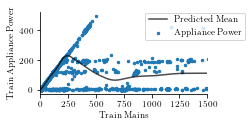

In [56]:
plt.figure()
latexify(width_scale_factor=2, fig_height=1.5)

start = 0
idx = 5000
plt.plot(x_lin1[:,49], y_mean, 'k', label=" Predicted Mean", alpha=0.7)
plt.scatter( scaler_x.inverse_transform(x_train_full)[:,49], scaler_y.inverse_transform(y_train.reshape(-1,1)), s = 6, label="Appliance Power")
plt.xlim(0,1500)
sns.despine()
plt.legend(bbox_to_anchor=(0.6, 0.6))
plt.xlabel("Train Mains")
plt.ylabel("Train Appliance Power")
# plt.show()
# savefig("Main_seq_vs_app_mean")


In [ ]:
x_lin_max = 3000
x_lin = np.linspace(0,x_lin_max,15656) # + 100*np.ones(np.array(x_test).shape[0])
x_lin_scale = scaler_x.transform(x_lin.reshape(-1,1)).flatten() 

x_new = torch.cat((torch.tensor(x_lin_scale).reshape(-1,1).to(torch.float32), torch.tensor(x_test_timestamp).reshape(-1,1)),dim=1 ).to(torch.float32)
x_new.shape, x_new.dtype

saving image to ./Figures/Seq_to_point_plt2_latexified.pdf
Figure size: [3.  1.5]


<Figure size 216x108 with 0 Axes>

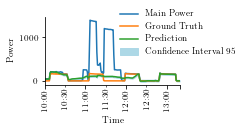

In [28]:
idx = 200 #x2.shape[0]
start = 4800

plt.figure()
latexify(width_scale_factor=2, fig_height=1.5)
df = pd.read_csv("time_stamp.csv", index_col=0)
df.index = df["0"]
df.index = pd.to_datetime(df.index)
df.index.name = "Time"
df = df.drop(columns=["0"])
df["Main Power"] =  scaler_x.inverse_transform(xt[:,0:99])[:,49]
df["Ground Truth"] = y_test
df["Prediction"] = y_mean
df[start:start+idx].plot(rot=90)
plt.fill_between(df.index[start : start + idx], y_mean[start : start + idx].flatten() - 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  y_mean[start : start + idx].flatten() + 1.96*np.sqrt(var_pred[start : start + idx]).flatten(),  color='lightblue', alpha=1.0, label = "Confidence Interval 95%)")
sns.despine()
# df.plot.( rotation=90)
plt.legend(frameon=False, bbox_to_anchor=(0.5, 0.3))
# df.head()
plt.ylabel("Power")
savefig("Seq_to_point_plt2")

saving image to Neurips/Plots/Seq_to_point_main_power_seq__added100_linear_plt_latexified.pdf
Figure size: [3.   1.75]


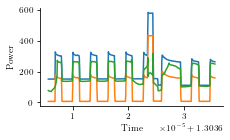

In [18]:
# idx = 500
# start = 4000
# plt.figure()
# time_plot = scaler_time.inverse_transform(x_test_timestamp.reshape(-1,1))
# latexify(width_scale_factor=2, fig_height=1.75)
# plt.plot(time_plot[start : start + idx], scaler_x.inverse_transform(xt[:,0:99])[:,49][start : start + idx], label = "Main Power")
# plt.plot(time_plot[start : start + idx], y_test[start : start + idx], label = "Ground Truth")
# plt.plot(time_plot[start : start + idx], y_mean[start : start + idx], label = "Prediction")
# # plt.legend(frameon=False, bbox_to_anchor=(0.6, 0.9))
# plt.xlabel("Time")
# plt.ylabel("Power")
# sns.despine()
# # plt.show()
# savefig("Seq_to_point_main_power_seq__a_linear_plt")

In [37]:
for name, params in model.named_parameters():
  print(name, params)

mll.likelihood.noise_covar.raw_noise Parameter containing:
tensor([-4.0766], device='cuda:0', requires_grad=True)
mll.model.mean_module.constant Parameter containing:
tensor([0.8700], device='cuda:0', requires_grad=True)
mll.model.base_covar_module.raw_outputscale Parameter containing:
tensor(-2.5899, device='cuda:0', requires_grad=True)
mll.model.base_covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[10.4251, 10.8671, 11.2113, 11.2482, 11.2213, 11.3358, 11.2443, 11.4213,
         11.6552, 11.6334, 11.7098, 11.4688, 11.5728, 11.4793, 11.4923, 11.6508,
         11.8268, 11.9869, 11.7231, 11.9634, 11.8792, 11.9776, 12.0374, 12.1292,
         12.1015, 12.1548, 12.1259, 12.0086, 12.0525, 12.0732, 12.0210, 11.6221,
         11.8350, 11.9144, 11.9817, 11.5319, 11.4422, 11.4816, 11.4924, 11.5062,
         11.4141, 11.4433, 11.4957, 11.4067, 11.4078, 11.1971, 11.1387,  9.9038,
          8.8081, -0.1963,  6.7484, 11.8245, 12.2235, 12.3450, 12.8252, 12.1872,
         12.199

(99,)


Text(0, 0.5, 'Learned Lengthscale Values')

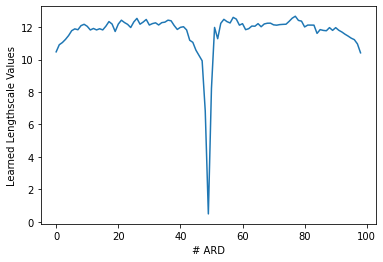

In [17]:
ar = np.arange(0,99,1)
print(ar.shape)
plt.plot(ar,model.mll.model.base_covar_module.base_kernel.lengthscale.cpu().detach().numpy().reshape(-1,))
plt.xlabel("# ARD")
plt.ylabel("Learned Lengthscale Values")